# Analyze orientation detection task during structure learning

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from tesser import tasks

bids_dir = os.environ['TESSER_BIDS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'plots')
os.makedirs(fig_dir, exist_ok=True)

In [2]:
raw = tasks.load_struct(bids_dir)
data = tasks.fix_struct_switched(raw)
data.head(5)

,onset,duration,trial_type,block,community,object,object_type,orientation,response,response_time,run,subject,part
0,0.0,1.5,structured,1,2,10,boundary,canonical,canonical,1.427,1,100,1
1,1.5,1.5,structured,1,2,5,central,canonical,canonical,0.759,1,100,1
2,3.0,1.5,structured,1,2,4,boundary,canonical,canonical,0.866,1,100,1
3,4.5,1.5,structured,1,1,3,boundary,canonical,canonical,0.713,1,100,1
4,6.0,1.5,structured,1,1,1,central,canonical,canonical,0.654,1,100,1


## Test whether performance was above chance

In [3]:
overall = data.groupby(['subject']).apply(tasks.test_rotation_perf, 10000)
overall['nr'] = 1 - overall['rr']
overall.agg(['mean', 'sem', 'min', 'max'])

,rr,hr,far,zhr,zfar,dprime,p,nr
mean,0.989286,0.927256,0.012586,1.595122,-2.428008,4.023130,1.000000e-04,0.010714
sem,0.001959,0.011725,0.003103,0.074188,0.064679,0.109553,4.517509e-21,0.001959
min,0.949125,0.580645,0.000481,0.203544,-3.301140,2.068007,1.000000e-04,0.000814
max,0.999186,0.994318,0.109885,2.531313,-1.227141,5.707123,1.000000e-04,0.050875


In [4]:
res = data.groupby(['subject', 'part', 'run']).apply(tasks.rotation_perf).reset_index()

## Part 1

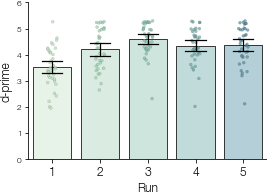

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 1'),
    x='run',
    y='dprime',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(ylim=(0, 6), xlabel='Run', ylabel="d-prime")
fig.savefig(os.path.join(fig_dir, 'orientation_part1_dprime.pdf'));

In [6]:
part1 = res.query('part == 1')
runs = part1.pivot(index='subject', columns='run', values='dprime')
pg.rm_anova(part1, dv='dprime', within='run', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,run,4,144,31.894377,5.053736e-19,0.469765,0.815958


In [7]:
# compare performance on adjacent runs
labels = [f'{r + 1} - {r}' for r in range(1, 5)]
tab_list = []
for r in range(1, 5):
    t = pg.ttest(runs[r + 1], runs[r], paired=True)
    diff = runs[r + 1] - runs[r]
    t['mean'] = diff.mean()
    t['sem'] = diff.sem()
    tab_list.append(t)
tab = pd.concat(tab_list, axis=0, ignore_index=True)
tab.index = labels
tab['pcor'] = pg.multicomp(tab['p-val'].to_numpy(), method='fdr_bh')[1]
tab

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,mean,sem,pcor
2 - 1,6.321663,36,two-sided,2.588415e-07,"[0.47, 0.91]",0.913540,6.076e+04,0.999713,0.688365,0.108890,0.000001
3 - 2,3.989797,36,two-sided,3.105943e-04,"[0.2, 0.61]",0.591043,88.912,0.937945,0.402626,0.100914,0.000621
4 - 3,-3.244320,36,two-sided,2.543796e-03,"[-0.43, -0.1]",0.411381,13.703,0.682675,-0.265563,0.081855,0.003392
5 - 4,0.247058,36,two-sided,8.062665e-01,"[-0.15, 0.19]",0.029677,0.182,0.053546,0.020866,0.084458,0.806266


## Part 2

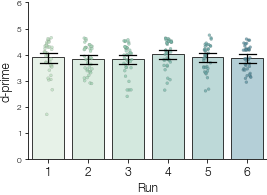

In [8]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 2'),
    x='run',
    y='dprime',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(ylim=(0, 6), xlabel='Run', ylabel="d-prime")
fig.savefig(os.path.join(fig_dir, 'orientation_part2_dprime.pdf'));

In [9]:
part2 = res.query('part == 2')
pg.rm_anova(part2, dv='dprime', within='run', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,run,5,180,1.125039,0.348718,0.030304,0.807415


In [10]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

numpy     : 1.18.1
tesser    : 0.1.0
pandas    : 1.2.5
matplotlib: 3.4.2
pingouin  : 0.3.12
mindstorm : 0.8.1
seaborn   : 0.11.1

